In [4]:
# importowanie potrzebnych bibliotek:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#-------------------------------------------------------
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.DataStructs.cDataStructs import ExplicitBitVect
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import PandasTools
from rdkit.Chem import rdMolDescriptors
from tqdm import tqdm
#--------------------------------------------------------
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import time
from sklearn.model_selection import ShuffleSplit, cross_validate,train_test_split
#--------------------------------------------------------
from lightgbm import LGBMRegressor

In [5]:
termo_database = pd.read_excel('C:/Users/mbkil/excele/Database _500.xlsx') 
termo_database.head()

# importujemy wykonaną przez nas baze danych

,Unnamed: 0,CAS,Substances,Molecular Weight [g/mol],Formula,SMILES,Critical_Temperature,Critical_Pressure,Critical_Volume
0,1,74-82-8,Methane,16.04,CH4,C,173.70,4599.0,0.099
1,2,74-84-0,Ethane,30.07,C2H6,CC,304.26,4580.0,0.145
2,3,74-98-6,Propane,44.10,C3H8,CCC,364.59,4242.6,0.198
3,4,106-97-8,Butane,58.12,C4H10,CCCC,423.90,3787.0,0.255
4,5,109-66-0,Pentane,72.15,C5H12,CCCCC,469.70,3370.0,0.295


In [6]:
termo_baza_podstawa = termo_database[["Critical_Temperature","Critical_Pressure","Critical_Volume","SMILES"]]
termo_baza_podstawa

# wyodrębniamy interesujące nas dane

,Critical_Temperature,Critical_Pressure,Critical_Volume,SMILES
0,173.70,4599.00,0.099,C
1,304.26,4580.00,0.145,CC
2,364.59,4242.60,0.198,CCC
3,423.90,3787.00,0.255,CCCC
4,469.70,3370.00,0.295,CCCCC
...,...,...,...,...
495,549.00,3970.00,0.324,CC(C)(C)CO
496,577.20,3930.00,0.329,CC(C)CCO
497,570.76,3916.03,0.329,CCC(C)CO
498,504.03,3431.89,0.328,CCC(C)OC


In [7]:
# tworzymy struktury 2d dla naszych SMILESÓW
PandasTools.AddMoleculeColumnToFrame(termo_baza_podstawa,'SMILES','Stucture',includeFingerprints=True)

C:\Users\mbkil\anaconda3\lib\site-packages\rdkit\Chem\PandasTools.py:381: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(


,Critical_Temperature,Critical_Pressure,Critical_Volume,SMILES,Stucture
0,173.70,4599.00,0.099,C,
1,304.26,4580.00,0.145,CC,
2,364.59,4242.60,0.198,CCC,
3,423.90,3787.00,0.255,CCCC,
4,469.70,3370.00,0.295,CCCCC,
...,...,...,...,...,...
495,549.00,3970.00,0.324,CC(C)(C)CO,
496,577.20,3930.00,0.329,CC(C)CCO,
497,570.76,3916.03,0.329,CCC(C)CO,
498,504.03,3431.89,0.328,CCC(C)OC,

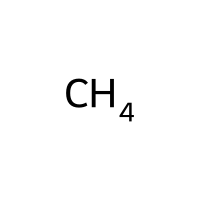
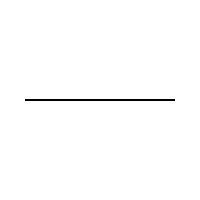
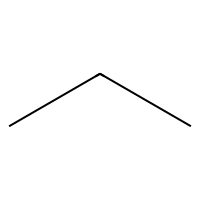
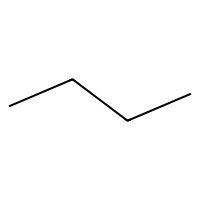
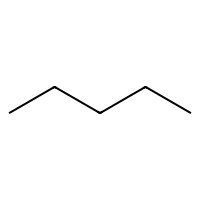
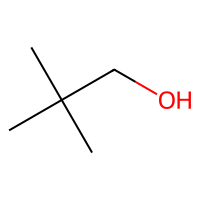
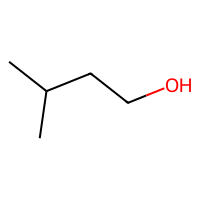
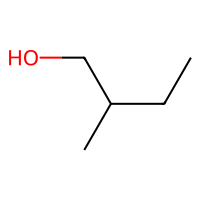
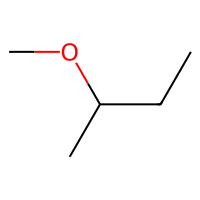
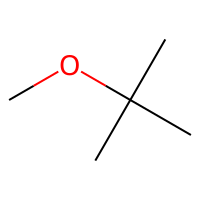

In [8]:
termo_baza_podstawa

In [9]:
def generate_AVfpts(data):
    
    Avalon_fpts = []
    
    for mol in tqdm(data):
      
        avfpts = pyAvalonTools.GetAvalonFP(mol, nBits=512)
        Avalon_fpts.append(avfpts)
        
    return np.array(Avalon_fpts)

# Tworzymy fingerprinty

In [10]:
Avalon_fpts = generate_AVfpts(termo_baza_podstawa['Stucture'])

100%|██████████| 500/500 [00:00<00:00, 3505.24it/s]


In [11]:
Avalon_fpts

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [12]:
# Przchowujemy fingerprinty w nowej bazie

Avalon_fingerprints = pd.DataFrame(Avalon_fpts, columns=['Col_A_{}'.format(i + 1) 
                                                        for i in range(Avalon_fpts.shape[1])])
Avalon_fingerprints

Avalon_fingerprints.to_excel("Avalon_fingerprints.xlsx", index=False)

In [42]:
Avalon_fingerprints

,Col_A_1,Col_A_2,Col_A_3,Col_A_4,Col_A_5,Col_A_6,Col_A_7,Col_A_8,Col_A_9,Col_A_10,...,Col_A_503,Col_A_504,Col_A_505,Col_A_506,Col_A_507,Col_A_508,Col_A_509,Col_A_510,Col_A_511,Col_A_512
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Wynik R2:  0.6898741979940516
Średni błąd bezwzględny (MEA):  23.85729847702625


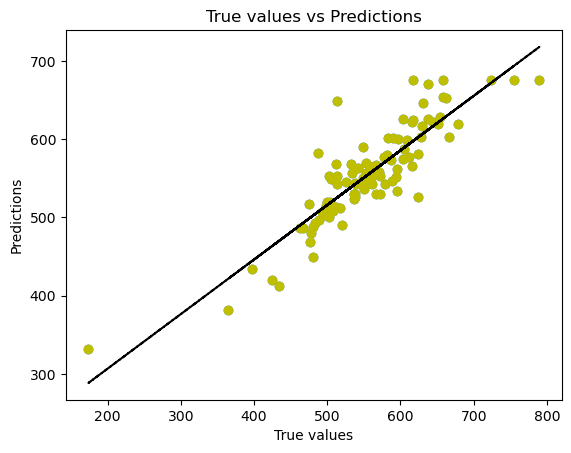

Total time required: 0.85 min


In [56]:
# Ustawiamy model:
lgbm_av = LGBMRegressor(n_estimators=800, random_state=42)
model_rf = RandomForestRegressor(random_state=42)

# Czas startu:
start = time.time()

# Walidacja krzyżowa:
cv = ShuffleSplit(n_splits=10, test_size=0.2,random_state=42)
scoring = ['r2','neg_mean_absolute_error']

X_train, X_test, y_train, y_test = train_test_split(Avalon_fingerprints, termo_baza_podstawa.Critical_Temperature, test_size=0.2, random_state=42)
lgbm_av.fit(X_train, y_train)
y_pred = lgbm_av.predict(X_test)

# Wyświetlamy wyniki
print("Wynik R2: ", abs(scores_val['test_r2'].mean()))
print("Średni błąd bezwzględny (MEA): ", abs(scores_val['test_neg_mean_absolute_error'].mean()))

# Tworzenie wykresu
plt.scatter(y_test, y_pred)
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.title('True values vs Predictions')

# Dodawanie lini regresji
fit = np.polyfit(y_test, y_pred, 1)
fit_fn = np.poly1d(fit)
plt.plot(y_test, y_pred, 'yo', y_test, fit_fn(y_test), '--k')

plt.show()

time.sleep(50)
# czas
end = time.time()

total_time = end - start
print('Total time required:', round(total_time/60, 2), 'min')